In [ ]:
import zipfile
path_to_zip_file = 'data.zip'
directory_to_extract_to = './data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [74]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tomkin import detect_rpeak
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from outlier_calculation import Quality,compute_outlier_ecg
from hrvanalysis import remove_ectopic_beats
from joblib import Parallel,delayed
from data_quality import ECGQualityCalculation
from joblib import delayed,Parallel
from copy import deepcopy
from ecg import ecg_feature_computation
from scipy import interpolate
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler,RobustScaler,QuantileTransformer
import gzip

def get_quality_rip(data):
    outlier_threshold_high = 4000
    outlier_threshold_low = 20
    SLOPE_THRESHOLD = 300
    RANGE_THRESHOLD = 200
    RIP_THRESHOLD_BAND_LOOSE = 175
    RIP_THRESHOLD_BAND_OFF = 20
    minimum_expected_samples = 3*(0.33)*21.33
    acceptable_outlier_percent = 34
    
    data_quality_band_loose = 'Loose/Improper Attachment'
    data_quality_not_worn = 'Sensor off Body'
    data_quality_band_off = 'Battery down/Disconnected'
    data_quality_missing = 'Interittent Data Loss' 
    data_quality_good = 'Acceptable'
    
    if (len(data)== 0):
        return data_quality_band_off
    if (len(data)<=minimum_expected_samples) :
        return data_quality_missing
    range_data = max(data)-min(data)
    if range_data<=RIP_THRESHOLD_BAND_OFF:
        return data_quality_not_worn
    if range_data<=RIP_THRESHOLD_BAND_LOOSE:
        return data_quality_band_loose
    outlier_counts = 0 
    
    for i in range(0,len(data)):
        im,ip  = i,i
        if i==0:
            im = len(data)-1
        else:
            im = i-1
        if i == len(data)-1:
            ip = 0
        else:
            ip = ip+1
        stuck = ((data[i]==data[im]) and (data[i]==data[ip]))
        flip = ((abs(data[i]-data[im])>((int(outlier_threshold_high)))) or (abs(data[i]-data[ip])>((int(outlier_threshold_high)))))
        disc = ((abs(data[i]-data[im])>((int(SLOPE_THRESHOLD)))) and (abs(data[i]-data[ip])>int(SLOPE_THRESHOLD)))
        if disc:
            outlier_counts += 1
        elif stuck:
            outlier_counts +=1
        elif flip:
            outlier_counts +=1
        elif data[i] >= outlier_threshold_high:
            outlier_counts +=1
        elif data[i]<= outlier_threshold_low:
            outlier_counts +=1
    if (100*outlier_counts>acceptable_outlier_percent*len(data)):
        return data_quality_band_loose
    return data_quality_good



def get_interpolated(aclx,acly,aclz):
    time_array = aclx[:,1].reshape(-1,1)
    aclxyz = np.concatenate([time_array,time_array,time_array,time_array],axis=1)
    f = interpolate.interp1d(aclx[:,1],aclx[:,0],fill_value='extrapolate')
    aclxyz[:,1] = f(aclxyz[:,0])
    f = interpolate.interp1d(acly[:,1],acly[:,0],fill_value='extrapolate')
    aclxyz[:,2] = f(aclxyz[:,0])
    f = interpolate.interp1d(aclz[:,1],aclz[:,0],fill_value='extrapolate')
    aclxyz[:,3] = f(aclxyz[:,0])
    return aclxyz


def get_clean_ecg(ecg_data):
    final_data = np.zeros((0,3))
    if len(ecg_data)==0:
        return final_data
    test_object = ECGQualityCalculation()
    start_ts = ecg_data[0,0]
    final_data = np.zeros((0,3))
    while start_ts<ecg_data[-1,0]:
        index = np.where((ecg_data[:,0]>=start_ts)&(ecg_data[:,0]<start_ts+3000))[0]
        temp_data = ecg_data[index,2]
        if test_object.current_quality(temp_data)==1:
            final_data = np.concatenate((final_data,ecg_data[index,:]))
        start_ts = start_ts + 3000
    return final_data


def get_hr(ecg_data):
#     try:
    rpeaks = detect_rpeak(ecg_data[:,2],64)
    rpeak_ts = ecg_data[rpeaks,0]
    ecg_rr = np.zeros((len(rpeaks)-1,2))
    ecg_rr_ts = np.array(rpeak_ts)[1:]
    ecg_rr_sample = np.array(np.diff(rpeak_ts))
    index = np.where((ecg_rr_sample>=300)&(ecg_rr_sample<=2000))[0]
    ecg_rr_ts = ecg_rr_ts[index]
    ecg_rr_sam = ecg_rr_sample[index]
    rr = remove_ectopic_beats(ecg_rr_sam)
    ecg_rr_sam = ecg_rr_sam[~np.isnan(rr)]
    ecg_rr_ts = ecg_rr_ts[~np.isnan(rr)]
    outlier = compute_outlier_ecg(ecg_rr_ts/1000,ecg_rr_sam/1000)
    ind1 = []
    for ind,tup in enumerate(outlier):
        if tup[1]==Quality.ACCEPTABLE:
            ind1.append(ind)
    ind1 = np.array(ind1)
    if len(ind1)<100:
        return [],[]
    ecg_rr_ts = ecg_rr_ts[ind1]
    ecg_rr_sam = ecg_rr_sam[ind1]
    return ecg_rr_ts,ecg_rr_sam
#     except Exception as e:
#         print(e)


def get_windows(data,window_size=10,offset=10,fs=1):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>t-window_size*1000/2)&(data[:,0]<=t+window_size*1000/2))[0]
        if len(index)<30:
            continue
        window_col.append(data[index,:])
    return window_col

def get_std_chest(window,start=1,end=4):
    return np.array([np.mean(window[:,0]),np.sqrt(np.sum(np.power(np.std(window[:,start:end],axis=0),2)))])


def filter_ecg_windows(ecg_windows,acl_std):
    final_ecg_windows = []
    for window in ecg_windows:
        index = np.where((acl_std[:,0]>window[0,0])&(acl_std[:,0]<window[-1,0]))[0]
        if len(index)==0:
            continue
        window_temp = acl_std[index,1].reshape(-1)
        if len(window_temp[window_temp>.21])/len(window_temp) > .5:
            continue
        final_ecg_windows.append(window)
    return final_ecg_windows
path = './data/'
participants = [path + f +'/' for f in os.listdir(path) if f[0]=='S']
for f in participants:
    if 'ecg.txt.gz' not in os.listdir(f):
        continue
    st = 0
    et = 0 
    with gzip.open(f+'stress_marks.txt.gz', 'r') as file:
        for line in file.readlines():
            line = line.decode('utf8').strip()
            parts = [x.strip() for x in line.split(',')]
            label = parts[0]
            if label[:2] in ['c1']:
                st = np.int64(parts[2])
                et = np.int64(parts[3])
#     aclx = pd.read_csv(f +'accelx.txt.gz', compression='gzip',
#                           sep=' ',header=None).values
#     acly = pd.read_csv(f +'accely.txt.gz', compression='gzip',
#                           sep=' ',header=None).values
#     aclz = pd.read_csv(f +'accelz.txt.gz', compression='gzip',
#                           sep=' ',header=None).values
#     acl_all = get_interpolated(aclx,acly,aclz)
#     aclx = ((3*acl_all[:,1].reshape(-1)/4095) - 1.5) / 0.3
#     acly = ((3*acl_all[:,2].reshape(-1)/4095) - 1.5) / 0.3
#     aclz = ((3*acl_all[:,3].reshape(-1)/4095) - 1.5) / 0.3
#     aclxyz = np.concatenate([acl_all[:,0].reshape(-1,1),aclx.reshape(-1,1),acly.reshape(-1,1),aclz.reshape(-1,1)],axis=1)
#     acl_windows = get_windows(aclxyz,window_size=10,offset=10,fs=15)
#     acl_std = np.array([get_std_chest(window) for window in acl_windows])
#     ecg_temp = pd.read_csv(f +'ecg.txt.gz', compression='gzip',
#                           sep=' ',header=None).values
#     print(ecg_temp.shape,f)
#     ecg = np.zeros((ecg_temp.shape[0],ecg_temp.shape[1]+1))
#     ecg[:,0],ecg[:,2] = ecg_temp[:,1],ecg_temp[:,0]
#     ecg_rr_ts,ecg_rr_sam = get_hr(ecg)
#     if len(ecg_rr_sam)<100:
#         continue
#     print(ecg_rr_ts.shape,f)
#     ecg_rr = np.zeros((len(ecg_rr_ts),2))
#     ecg_rr[:,0] = ecg_rr_ts
#     ecg_rr[:,1] = ecg_rr_sam
    if os.path.isfile(f+'ecg_rr.p') and st>0:
        ecg_rr = pickle.load(open(f+'ecg_rr.p','rb'))
        ecg_rr_baseline = ecg_rr
#         ecg_rr_baseline = ecg_rr[np.where((ecg_rr[:,0]>=st)&(ecg_rr[:,0]<=et))[0],:]
#         ecg_rr_baseline = ecg_rr[np.where((ecg_rr[:,1]>=np.percentile(ecg_rr[:,1],45))&(ecg_rr[:,1]<=np.percentile(ecg_rr[:,1],95)))[0],:]
        from scipy import stats
#         ecg_rr_baseline[:,1] = stats.mstats.winsorize(ecg_rr_baseline[:,1],limits=[.1,.01])
#         ecg_windows1 = get_windows(ecg_rr_baseline,window_size=60,offset=30,fs=1)
#         mean_col = [np.mean(window[:,1]) for window in ecg_windows1]
#         std_col = [np.std(window[:,1]) for window in ecg_windows1]
        ecg_rr[:,1] = stats.mstats.winsorize(ecg_rr[:,1],limits=.1)
#         m = np.mean(ecg_rr_baseline[:,1])
#         s = np.std(ecg_rr_baseline[:,1])
#         m = np.percentile(mean_col,45)
#         s = np.percentile(std_col,55)
#         ecg_rr[:,1] = (ecg_rr[:,1] - m)/s
#         ecg_rr[ecg_rr[:,1]<-4,1] = -4
#         ecg_rr[ecg_rr[:,1]>4,1] = 4
    #     ecg_rr[:,1] = preprocessing.RobustScaler().fit_transform(ecg_rr[:,1].reshape(-1,1)).reshape(-1)
    #     plt.plot(ecg_rr[:,0],ecg_rr[:,1])
    #     plt.show()
        ecg_windows = get_windows(ecg_rr,window_size=60,offset=30,fs=1)
    #     final_ecg_windows = filter_ecg_windows(ecg_windows,acl_std)
        final_ecg_windows = ecg_windows
#         print(final_ecg_windows[0][:3])
        ecg_features = np.array([np.array([window[0,0],window[-1,0]]+ecg_feature_computation(window[:,0],window[:,1])) for window in final_ecg_windows])
    #     print(ecg_features)
#         ecg_features[:,2:] = StandardScaler().fit_transform(ecg_features[:,2:])
#         from scipy.stats import iqr
        for i in range(2,13,1):
#             ecg_features[:,i] = stats.mstats.winsorize(ecg_features[:,i],limits=.1)
            ecg_features[:,i] = StandardScaler().fit_transform(ecg_features[:,i].reshape(-1,1)).reshape(-1)
#         ecg_features[ecg_features>4] = 4
#         ecg_features[ecg_features<-4] = -4
#             print(iqr(ecg_features[:,i]))
        print(len(ecg_windows),len(final_ecg_windows),ecg_features.shape,path,f,ecg_features[0,-1])
        pickle.dump(ecg_features,open(f+'features22.p','wb'))
    
    
#     plt.plot(ecg_rr_ts,ecg_rr_sam)
#     plt.show():,

238 238 (238, 13) ./data/ ./data/SI01/ 1.8249798418708332
281 281 (281, 13) ./data/ ./data/SI02/ 2.2598144672842433
255 255 (255, 13) ./data/ ./data/SI03/ 1.8196751441063839
244 244 (244, 13) ./data/ ./data/SI04/ 1.0905312357305839
260 260 (260, 13) ./data/ ./data/SI06/ 2.362974777652327
278 278 (278, 13) ./data/ ./data/SI07/ 2.019693695794838
126 126 (126, 13) ./data/ ./data/SI08/ 1.0243091637247521
271 271 (271, 13) ./data/ ./data/SI10/ 2.377743099340151
261 261 (261, 13) ./data/ ./data/SI12/ 2.251085750636629
261 261 (261, 13) ./data/ ./data/SI13/ 2.506466586694521
300 300 (300, 13) ./data/ ./data/SI15/ 1.4477540167939862
277 277 (277, 13) ./data/ ./data/SI16/ 2.4775716721485446
266 266 (266, 13) ./data/ ./data/SI17/ 1.7043732928132331
255 255 (255, 13) ./data/ ./data/SI18/ 1.721245739348535
255 255 (255, 13) ./data/ ./data/SI19/ 1.5782262353769496
262 262 (262, 13) ./data/ ./data/SI20/ 2.3842863728854926
260 260 (260, 13) ./data/ ./data/SI21/ 2.120907323525026
255 255 (255, 13) ./d

In [82]:
# Soujanya Chatterjee
	
# 2:06 PM (9 minutes ago)
	
# to me
import pandas as pd, numpy as np, os, csv, glob, math, matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from scipy.stats import *
import gzip
import pickle
from collections import Counter

def find_majority(k):
    myMap = {}
    maximum = ( '', 0 ) # (occurring element, occurrences)
    for n in k:
        if n in myMap: myMap[n] += 1
        else: myMap[n] = 1

        # Keep track of maximum on the go
        if myMap[n] > maximum[1]: maximum = (n,myMap[n])

    return maximum[0]

# _dir = 'W:\\Students\\cstress_features\\data\\data\\SI02\\'

def decodeLabel(label):
    label = label[:2]  # Only the first 2 characters designate the label code

    mapping = {'c1': 0, 'c2': 1, 'c3': 1, 'c4': 2, 'c5': 0, 'c6': 1, 'c7': 2}

    return mapping[label]

def readstressmarks(participantID, filename):
    features = []
    for file in os.listdir(filename):    
        if file.endswith("marks.txt.gz"):        
            with gzip.open(os.path.join(filename, file), 'r') as file:
                for line in file.readlines():
#                     print(line)
                    line = line.decode('utf8').strip()
                    parts = [x.strip() for x in line.split(',')]                    
                    label = parts[0][:2]  
                    if label not in ['c4','c7']:
                        stressClass = decodeLabel(label)
                        features.append([participantID, stressClass, int(parts[2]), int(parts[3])])
    return np.array(features)
_dirr = './data/'
parti = np.array(os.listdir(_dirr) )
print(parti)
header = ['participant','starttime','endtime','label','f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8','f_9','f_10','f_11']
fea_cols = ['f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8','f_9','f_10','f_11']
data = []
for p in parti:
    if p in ['feature.csv','feature_ecg.csv','feature_rip.csv','SI05','SI09','SI11','SI14','SI23','SI24','.ipynb_checkpoints']:
        continue
    else:
        if os.path.isdir(os.path.join(_dirr,p)):
           
            _dir = (os.path.join(_dirr,p))
            gt_marks = readstressmarks(p,_dir)
            groundtruth = pd.DataFrame({'participant': gt_marks[:, 0], 'label': gt_marks[:, 1], 'starttime': gt_marks[:, 2],
                                        'endtime': gt_marks[:, 3]}, columns=['participant','label','starttime','endtime'])
            groundtruth = groundtruth.sort_values('starttime')
   

            for file in os.listdir(_dir):    
                    if file.endswith("22.p"):                    
                        with open(_dir+'/'+file, 'rb') as f:  
                            x = pickle.load(f)
#             print(x)
            dataset = pd.DataFrame({'starttime': x[:, 0], 'endtime': x[:, 1], 'f_1': x[:, 2]
                                   , 'f_2': x[:, 3], 'f_3': x[:, 4], 'f_4': x[:, 5]
                                   , 'f_5': x[:, 6], 'f_6': x[:, 7], 'f_7': x[:, 8]
                                   , 'f_8': x[:, 9], 'f_9': x[:, 10], 'f_10': x[:, 11]
                                   , 'f_11': x[:, 12]}, columns=['starttime','endtime','f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8',
                                                                 'f_9','f_10','f_11'])
           
            dataset = dataset.sort_values('starttime')

            for gt in range(len(dataset)):
                starttime = int(dataset['starttime'].iloc[gt])
                endtime = int(dataset['endtime'].iloc[gt])
                result = []
                for line in range(len(groundtruth)):
                    id, gtt, st, et = [groundtruth['participant'].iloc[line], groundtruth['label'].iloc[line], int(groundtruth['starttime'].iloc[line]),
                                      int(groundtruth['endtime'].iloc[line])]
                    if starttime < st:
                        continue
                    else:
                        if (starttime > st) and (endtime < et):
                            result.append(gtt)
                        if result:
                            fea = list(dataset[fea_cols].iloc[gt])
                            inter_data = [p, st,et,find_majority(result)],(fea)
                            flatten = lambda l: [item for sublist in l for item in sublist]

                            data.append(flatten(inter_data))
    #         print(data)
df = pd.DataFrame(data)
df.to_csv(_dirr + '/' + 'feature_ecg.csv', index=False, header=header)
df.shape

['.DS_Store' 'SI01' 'SI02' 'SI03' 'SI04' 'SI05' 'SI06' 'SI07' 'SI08'
 'SI09' 'SI10' 'SI11' 'SI12' 'SI13' 'SI14' 'SI15' 'SI16' 'SI17' 'SI18'
 'SI19' 'SI20' 'SI21' 'SI22' 'SI23' 'SI24' '.ipynb_checkpoints'
 'feature.csv' 'feature_rip.csv' 'feature_ecg.csv']


(1617, 15)

In [83]:
feature_file = './data/feature_ecg.csv'
feature = pd.read_csv(feature_file).values
y = np.int64(feature[:,3])
X = feature[:,4:]
print(X.shape,y.shape,np.sum(y))
groups = feature[:,0]

(1617, 11) (1617,) 980


In [84]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed

delta = 0.1

paramGrid = {'kernel': ['rbf'],
             'C': np.logspace(.1,4,5),
             'gamma': [np.power(2,np.float(x)) for x in np.arange(-4, 4, .5)],
             'class_weight': [{0: w, 1: 1 - w} for w in [.4,.3,.2]],
             'probability':[True]
}
# clf = Pipeline([('rf', SVC())])
clf = SVC()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='f1_weighted',verbose=5)
grid_search.fit(X,y)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Fitting 18 folds for each of 240 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 2946 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  1.9min finished


Best parameter (CV score=0.893):
{'C': 11.885022274370183, 'class_weight': {0: 0.4, 1: 0.6}, 'gamma': 0.08838834764831845, 'kernel': 'rbf', 'probability': True}


In [78]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups))
print(confusion_matrix(y,y_pred),classification_report(y,y_pred))

[[999 126]
 [192 300]]               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1125
           1       0.70      0.61      0.65       492

   micro avg       0.80      0.80      0.80      1617
   macro avg       0.77      0.75      0.76      1617
weighted avg       0.80      0.80      0.80      1617



In [79]:
import pickle
clf.set_params(probability=True)
print(clf)
clf.fit(X,y)
pickle.dump(clf,open('/home/jupyter/mullah/cc3/ecg_model_feature_standardization.p','wb'))

SVC(C=1.2589254117941673, cache_size=200, class_weight={0: 0.4, 1: 0.6},
  coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0625,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [80]:
from sklearn_porter import Porter
porter = Porter(clf, language='java')
output = porter.export(export_data=True)
# print(output)
text_file = open("SVM1.java", "w")
text_file.write(output)
text_file.close()
print(clf.probA_,clf.probB_)

[-1.56928047] [-0.35841392]


0.6866310160427808 0.38159560784543295 [[1012  113]
 [ 179  313]]


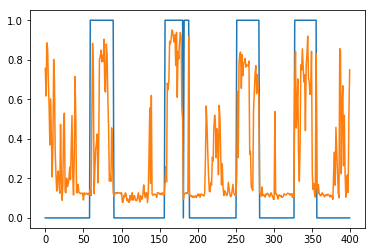

In [81]:
from sklearn import metrics
def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
score, bias = f1Bias_scorer_CV(clf.predict_proba(X)[:,1], y, True)
print(score,bias,confusion_matrix(y,clf.predict(X)))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y[:400])
plt.plot(grid_search.predict_proba(X)[:400,1])

In [ ]:
### from sklearn.decomposition import PCA
from pprint import pprint
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
warnings.filterwarnings('ignore')
from sklearn import metrics


feature_file = './data/feature.csv'
feature = pd.read_csv(feature_file).values
y = np.int64(feature[:,3])
X = feature[:,4:]
print(X.shape,y.shape,np.sum(y))
groups = feature[:,0]
# print(groups)
# # print(feature.head())
def fit3(params,X,y,groups,gkf):
    pca = PCA(n_components=4)
#     model = SVC(**params)
    model = RandomForestClassifier(**params)
    clf = Pipeline([('rf', model)])
    predicted = cross_val_predict(model, X, y, cv=gkf.split(X,y,groups=groups))
    print(f1_score(y,predicted))
    return np.array([f1_score(y,predicted),clf])
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
paramGrid = ParameterGrid({
    'min_samples_leaf': [2,3,4,5],
    'max_features': [.5,.7,1],
    'n_estimators': [500],
    'n_jobs': [-1],
    'criterion':['gini','entropy'],
    'random_state': [42],
    'class_weight':[{0:1,1:5}]
       })
# paramGrid = ParameterGrid({
#     'kernel':['rbf'],
#     'C':np.logspace(1,3,10),
#     'gamma':np.logspace(-5,5,80),
#     'class_weight':[{0:1,1:3}]
#        })
print(np.sum(y))
gkf = GroupKFold(n_splits=len(np.unique(groups)))
from scipy.stats import mstats
# X = preprocessing.StandardScaler().fit_transform(X)
# X = mstats.winsorize(X, limits=[0.02, 0.02])
# X = preprocessing.StandardScaler().fit_transform(X)
# f_col = np.array([fit3(params,X[:,:],y,groups,gkf) for params in paramGrid])
# pprint(max(f_col[:,0]))
# clf = f_col[np.argmax(f_col[:,0]),1]

def Twobias_scorer_CV(probs, y, ret_bias=False):
    db = np.transpose(np.vstack([np.array(probs).reshape(-1), np.array(y).reshape(-1)]))
    db = db[np.argsort(db[:, 0]), :]

    pos = np.sum(y == 1)
    n = len(y)
    neg = n - pos
    tp, tn = pos, 0
    lost = 0

    optbias = []
    minloss = 1

    for i in range(n):
        #		p = db[i,1]
        if db[i, 1] == 1:  # positive
            tp -= 1.0
        else:
            tn += 1.0

        # v1 = tp/pos
        #		v2 = tn/neg
        if tp / pos >= 0.95 and tn / neg >= 0.95:
            optbias = [db[i, 0], db[i, 0]]
            continue

        running_pos = pos
        running_neg = neg
        running_tp = tp
        running_tn = tn

        for j in range(i + 1, n):
            #			p1 = db[j,1]
            if db[j, 1] == 1:  # positive
                running_tp -= 1.0
                running_pos -= 1
            else:
                running_neg -= 1

            lost = (j - i) * 1.0 / n
            if running_pos == 0 or running_neg == 0:
                break

            # v1 = running_tp/running_pos
            #			v2 = running_tn/running_neg

            if running_tp / running_pos >= 0.95 and running_tn / running_neg >= 0.95 and lost < minloss:
                minloss = lost
                optbias = [db[i, 0], db[j, 0]]

    if ret_bias:
        return -minloss, optbias
    else:
        return -minloss
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    parameters : dict or None
        Parameters to be set on the estimator.
    cv:	Cross-validation fold indeces
    Returns
    -------
    score : float
        CV score on whole set.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    estimator.set_params(**parameters)
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)

    return [score, parameters]  # scoring_time
    
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    probs = cross_val_predict(estimator, X, y, cv=cv,method='predict_proba')[:,1]
#     for train, test in cv:
#         temp = estimator.fit(X[train], y[train]).predict_proba(X[test])
#         probs[test] = temp[:, 1]

    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise'):

        super(ModifiedGridSearchCV, self).__init__(
                estimator, param_grid, scoring, fit_params, n_jobs, iid,
                refit, cv, verbose, pre_dispatch, error_score)

    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
#         cv = check_cv(cv, X, y, classifier=is_classifier(estimator))

        if self.verbose > 0:
#             if isinstance(parameter_iterable, Sized):
            n_candidates = len(parameter_iterable)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv)
                for parameters in parameter_iterable)
#         print(out)
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]

        if self.refit:
            # fit the best estimator using the entire dataset
            # clone first to work around broken estimators
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
#             if y is not None:
#                 best_estimator.fit(X, y, **self.fit_params)
#             else:
#                 best_estimator.fit(X, **self.fit_params)
            self.best_estimator_ = best_estimator

        return self

In [ ]:
X1 = preprocessing.StandardScaler().fit_transform(X)
delta = 0.1
parameters = {'kernel': ['rbf'],
              'C': np.logspace(0,2,2),
              'gamma': np.logspace(-9,9,10),
              'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
              'probability':[False],
              'verbose':[False],
              'cache_size':[2000]}
parameters = {
    'min_samples_leaf': [2,3,4,5],
    'max_features': [.5,.7,1,.6],
    'n_estimators': [100,200,300],
    'n_jobs': [-1],
    'criterion':['gini','entropy'],
    'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
    'random_state': [42]
       }
svc = SVC()
svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups), 
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
grid_search = ModifiedGridSearchCV(svc, parameters, cv=list(gkf.split(X1,y,groups=groups)),
                                   n_jobs=40, scoring=f1Bias_scorer_CV, verbose=1, iid=False)
grid_search.fit(X1,y)
clf = grid_search.best_estimator_
clf

In [ ]:
# clf = SVC(C=1000.0, cache_size=2000, class_weight={0: 0.30000000000000004, 1: 0.7},
#   coef0=0.0, decision_function_shape='ovr', degree=3,
#   gamma=0.0018233480008684423, kernel='sigmoid', max_iter=-1,
#   probability=True, random_state=None, shrinking=True, tol=0.001,
#   verbose=False)
clf.probability = True
clf

In [ ]:
CV_probs = cross_val_probs(clf, X1, y, gkf.split(X1,y,groups=groups))
# score, bias = Twobias_scorer_CV(CV_probs, y, True)
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
classified = range(n)
print(score,bias)

f = np.zeros((len(y),2))

data = pd.DataFrame()
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

data['groups'] = groups
data['original'] = [[i] for i in y]
data['predicted'] = [[i] for i in predicted]
f_scores = []
data = data.groupby('groups').sum()
for i in range(data.shape[0]):
    f_scores.append(f1_score(data['original'][i],data['predicted'][i]))
print(np.median(f_scores))

In [ ]:
# scores = []
#     clf = RandomForestClassifier(**params)
#     clf = Pipeline([('rf', svc)])
# probs = cross_val_predict(svc, X, y, cv=gkf.split(X,y,groups=groups))
#         tmp = deepcopy(probs)
#         tmp[tmp>=c] = 1
#         tmp[tmp<c] = 0
score,bias = Twobias_scorer_CV(CV_probs, y,True)
print(score,bias)
# CV_probs = probs.reshape(-1)
classified = np.where((CV_probs <= bias[0])|(CV_probs >= bias[1]))[0]
predicted = np.asarray(CV_probs[classified] >= bias[1], dtype=np.int)
print(classification_report(y[classified], predicted))
#         print(f1_score(y,tmp),c,params['gamma'],params['C'])
        
#         np.array([f1_score(y,tmp),c,tmp]))
#         all_scores = np.array(all_scores)
#         ind_max = np.argmax(all_scores[:,0])
        
#     for train_index, test_index in gkf.split(X,y,groups=groups):
#         clf = RandomForestClassifier(**params)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         clf.fit(X_train,y_train)
#         y_pred = clf.predict(X_test)
#         scores.append(f1_score(y_test,y_pred))
#     print(np.mean(scores),params)

In [ ]:
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
from sklearn.base import clone, is_classifier

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.DataFrame(np.random.randn(10,3),columns=list('ABC'))

In [5]:
df['A'].loc[0]

0.053646767755833435